In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.datasets import fetch_datasets
from imblearn.over_sampling import SMOTE
from collections import Counter
import os
import sys
sys.path.append('/Users/tristenmarto/Documents/Studie/Thesis/Synthsonic_data_analysis')
from sklearn.preprocessing import StandardScaler, LabelEncoder, Binarizer
from sklearn.decomposition import PCA
from xgboost.sklearn import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sv_synthsonic import synthsonic, load_data, pca_plot
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold

In [50]:
X,y,title = load_data('ecoli')
clf = DecisionTreeClassifier(random_state=5, min_samples_leaf=6, max_depth = 30)
over = synthsonic(random_state=5, proportion=1)

2021-07-15 13:31:42,044:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1, 'distinct_threshold': -1, 'random_state': 5, 'do_PCA': True}")
2021-07-15 13:31:42,044:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1, 'distinct_threshold': -1, 'random_state': 5, 'do_PCA': True}")
n_quantiles (500) is greater than the total number of samples (28). n_quantiles is set to num samples.
Building tree: 100%|██████████| 15/15.0 [00:00<00:00, 1640.58it/s]
Generating for node: 4:  29%|██▊       | 2/7 [00:00<00:00,  9.54it/s]/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:522: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  "Found unknown state name. Trying to switch to using all state names as state numbers"
Generating for node: 3: 100%|██████████| 7/7 [00:01<00:00,  4.25it/s]
/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/sklearn/isotonic.py:71: 

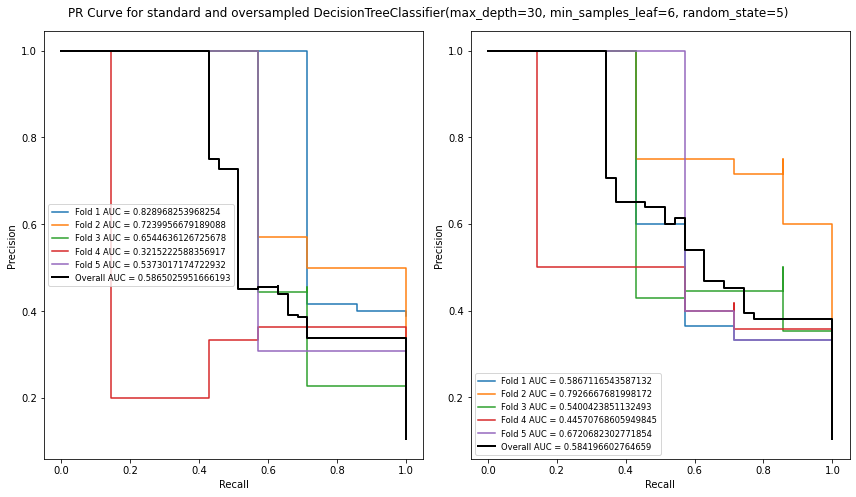

In [51]:
# make plots
f, axes = plt.subplots(1, 2, figsize=(12, 7))
f.suptitle(f"PR Curve for standard and oversampled {clf}")

# do kfold cross val and plot the PR curves
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

y_real = []
y_proba = []
for i, (train_index, test_index) in enumerate(k_fold.split(X,y), 1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    

    clf.fit(X_train, y_train)
    probas = clf.predict_proba(X_test)
    precision, recall, _ = precision_recall_curve(y_test, probas[:,1])
    lab = f"Fold {i} AUC = {auc(recall, precision)}"
    axes[0].step(recall, precision, label=lab)
    y_real.append(y_test)
    y_proba.append(probas[:,1])

y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, _ = precision_recall_curve(y_real, y_proba)
lab = f"Overall AUC = {auc(recall, precision)}"
axes[0].step(recall, precision, label=lab, lw=2, color='black')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].legend(fontsize='small')

# do kfold cross val and plot the PR curves
y_real = []
y_proba = []
for i, (train_index, test_index) in enumerate(k_fold.split(X,y), 1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    

    # generate samples
    try :
        X_train, y_train = over.sample(X_train, y_train)

    except :
        X_train, y_train = over.fit_resample(X_train, y_train)

    clf.fit(X_train, y_train)
    probas = clf.predict_proba(X_test)
    precision, recall, _ = precision_recall_curve(y_test, probas[:,1])
    lab = f"Fold {i} AUC = {auc(recall, precision)}"
    axes[1].step(recall, precision, label=lab)
    y_real.append(y_test)
    y_proba.append(probas[:,1])

y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, _ = precision_recall_curve(y_real, y_proba)
lab = f"Overall AUC = {auc(recall, precision)}"
axes[1].step(recall, precision, label=lab, lw=2, color='black')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].legend(fontsize='small')

f.tight_layout()

In [52]:
def classify(dataset, over, clf) :
    
    X,y,title = load_data(dataset)
    # single split
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33, stratify = y, random_state = 5)
    X_g, y_g = over.sample(X_train, y_train)
    clf.fit(X_g, y_g)
    pred = clf.predict(X_test)
    probas = clf.predict_proba(X_test)

    print("class imbalance:",Counter(y))

    return pred, probas

def get_pr_curve(y_true, probas, thresholds) :
    
    xax = []
    yax = []
    
    for thr in thresholds :
        preds = Binarizer(threshold=thr).fit_transform([probas]).ravel()
        tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()
        precision = tp/(fp+tp)
        recall = tp/(tp+fn)
        
        xax.append(recall)
        yax.append(precision)
        
    return xax, yax

2021-07-15 13:32:02,153:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1, 'distinct_threshold': -1, 'random_state': 5, 'do_PCA': True}")
2021-07-15 13:32:02,153:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1, 'distinct_threshold': -1, 'random_state': 5, 'do_PCA': True}")
n_quantiles (500) is greater than the total number of samples (23). n_quantiles is set to num samples.
Building tree: 100%|██████████| 15/15.0 [00:00<00:00, 1895.59it/s]
Generating for node: 0:   0%|          | 0/7 [00:00<?, ?it/s]/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:522: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  "Found unknown state name. Trying to switch to using all state names as state numbers"
Generating for node: 4: 100%|██████████| 7/7 [00:01<00:00,  5.75it/s]
/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/sklearn/isotonic.py:71: UserWarn

class imbalance: Counter({0: 301, 1: 35})


/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


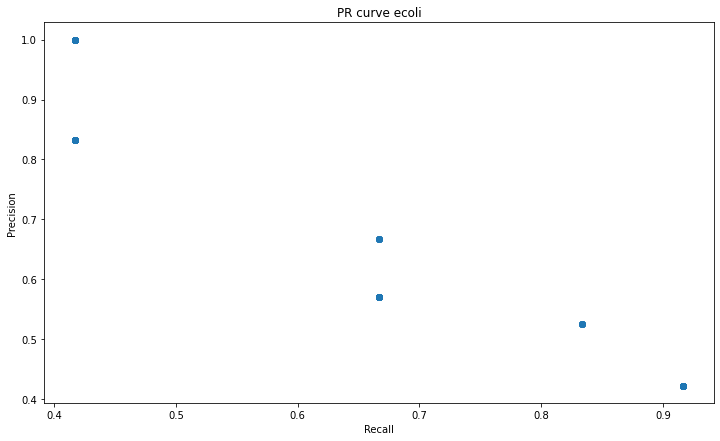

In [53]:
X,y,title = load_data('ecoli')
pred, probas = classify('ecoli', over, clf)
thresholds = np.linspace(0,1,num=100)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33, stratify = y, random_state = 5)
xax, yax = get_pr_curve(y_test, probas[:,1], thresholds)
plt.figure(figsize=(12,7))
plt.title("PR curve ecoli")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.scatter(xax, yax)

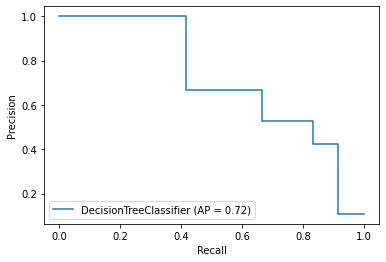

In [54]:
plot_precision_recall_curve(clf, X_test, y_test)

2021-07-15 13:32:05,965:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1, 'distinct_threshold': -1, 'random_state': 5, 'do_PCA': True}")
2021-07-15 13:32:05,965:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1, 'distinct_threshold': -1, 'random_state': 5, 'do_PCA': True}")
n_quantiles (500) is greater than the total number of samples (23). n_quantiles is set to num samples.
Building tree: 100%|██████████| 15/15.0 [00:00<00:00, 1907.89it/s]
Generating for node: 0:   0%|          | 0/7 [00:00<?, ?it/s]/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:522: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  "Found unknown state name. Trying to switch to using all state names as state numbers"
Generating for node: 4: 100%|██████████| 7/7 [00:01<00:00,  4.61it/s]
/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/sklearn/isotonic.py:71: UserWarn

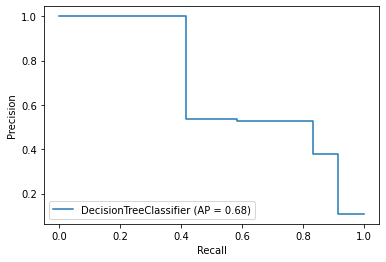

In [55]:
X_train, y_train = over.sample(X_train,y_train)
clf.fit(X_train,y_train)
plot_precision_recall_curve(clf, X_test, y_test)

In [56]:
probas

array([[1.        , 0.        ],
       [0.77777778, 0.22222222],
       [0.        , 1.        ],
       [0.83333333, 0.16666667],
       [0.28571429, 0.71428571],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.77777778, 0.22222222],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.44444444, 0.55555556],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.83333333, 0.16666667],
       [1.        , 0.        ],
       [0.44444444, 0.55555556],
       [1.        , 0.        ],
       [1.